# imports

In [ ]:
import numpy as np
from pymanopt import Problem
from pymanopt.manifolds import SpecialOrthogonalGroup
from pymanopt.optimizers import SteepestDescent
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import torch
from glob import glob

# align gaussian blob

In [2]:
def f1(xyz, mu, inv_sigma):
    """
    Gaussian function centered at mu with covariance matrix sigma.
    """
    diff = xyz - mu
    exponent = -0.5 * torch.sum(diff @ inv_sigma * diff, axis=1)
    return np.exp(exponent)

In [3]:
np.random.seed(0)
xyz = np.random.rand(100, 3)

# Define the Gaussian parameters
dtype = torch.float64
mu = torch.tensor([0, 0, 0]).to(dtype)
inv_sigma = (torch.diag(torch.tensor([1.0, 2.0, 3.0])) / 0.1).to(dtype)

n_pix = 128
x = y = z = torch.linspace(-1, 1, n_pix).to(dtype)
xx, yy, zz = torch.meshgrid(x, y, z)
xyz = torch.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

f = f1(xyz, mu, inv_sigma).numpy()

/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1739309769701/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
# from cryo_challenge._preprocessing.fourier_utils import downsample_volume
# ds = downsample_volume(torch.from_numpy(f.reshape(n_pix,n_pix,n_pix)), 64)
# plt.imshow(ds[32])

# two = torch.stack([torch.from_numpy(f.reshape(n_pix,n_pix,n_pix)), torch.from_numpy(f.reshape(n_pix,n_pix,n_pix))])
# downsample_volume(two, 64).shape

In [5]:
torch.linalg.norm(torch.ones(3, 3, 3) - torch.zeros(3, 3, 3))

tensor(5.1962)

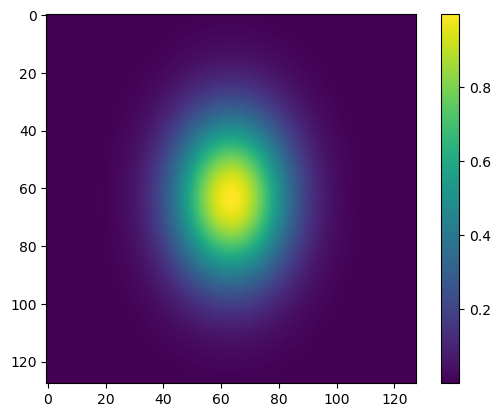

In [6]:
plt.imshow(f.reshape(n_pix, n_pix, n_pix)[:, :, n_pix // 2])
plt.colorbar()

In [7]:
fixed_rotation = torch.from_numpy(
    R.from_euler("ZXZ", [45, 0, 0], degrees=True).as_matrix()
)
f_fixed = f1(xyz @ fixed_rotation.T, mu, inv_sigma)
fixed_rotation

tensor([[ 0.7071, -0.7071,  0.0000],
        [ 0.7071,  0.7071,  0.0000],
        [ 0.0000,  0.0000,  1.0000]], dtype=torch.float64)

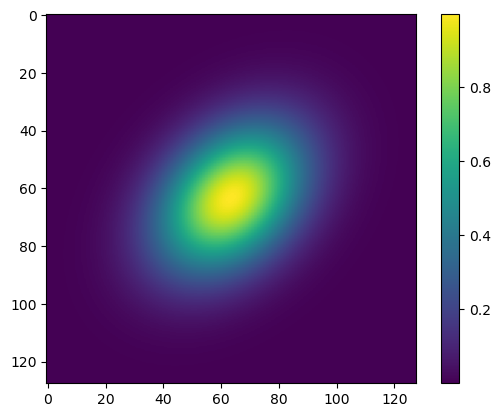

In [8]:
plt.imshow(f_fixed.reshape(n_pix, n_pix, n_pix)[:, :, n_pix // 2])
plt.colorbar()

Optimizing...
                                            f: +7.007264e-01   |grad|: 5.677140e+01
acc       k:     1     num_inner:     1     f: +1.232495e-07   |grad|: 2.381402e-02   model increased
acc       k:     2     num_inner:     1     f: +5.192997e-28   |grad|: 7.461801e-13   model increased
Terminated - min grad norm reached after 2 iterations, 1.86 seconds.

Optimal rotation matrix (R):
OptimizerResult(point=array([[ 7.07106781e-01, -7.07106781e-01, -1.03894328e-20],
       [ 7.07106781e-01,  7.07106781e-01,  4.93088999e-21],
       [ 3.85977266e-21, -1.08331042e-20,  1.00000000e+00]]), cost=array(5.19299713e-28), iterations=2, stopping_criterion='Terminated - min grad norm reached after 2 iterations, 1.86 seconds.', time=1.8591160774230957, cost_evaluations=None, step_size=None, gradient_norm=7.461801403997632e-13, log={'optimizer': 'TrustRegions', 'stopping_criteria': {'max_time': 1000, 'max_iterations': 100, 'min_gradient_norm': 1e-06, 'min_step_size': 1e-10, 'max_cost_ev

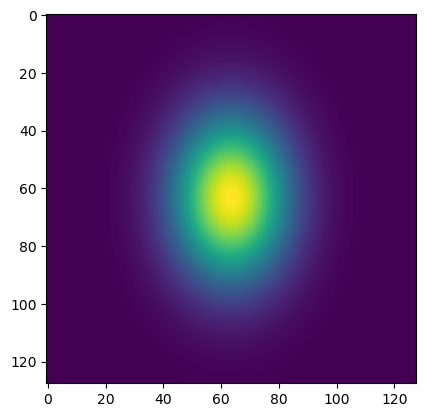

In [14]:
import torch
import matplotlib.pyplot as plt
import pymanopt
from pymanopt.optimizers.trust_regions import TrustRegions

# # Define the Gaussian parameters
# mu = torch.tensor([0.5, 0.5, 0.5], requires_grad=False).to(dtype)
# inv_sigma = (torch.diag(torch.tensor([1.0, 2.0, 3.0], requires_grad=False)) / 0.1**2).to(dtype)


# Define the Gaussian function with a 3x3 covariance matrix
def f1(xyz, mu, inv_sigma):
    """
    Gaussian function centered at mu with covariance matrix sigma.
    """
    diff = xyz - mu
    exponent = -0.5 * torch.sum(diff @ inv_sigma * diff, axis=1)
    return torch.exp(exponent)


# Define the loss function (L2 loss)
@pymanopt.function.pytorch(SpecialOrthogonalGroup(3))
def loss(rotation):
    # Apply the rotation R to the coordinates
    rotated_xyz = xyz @ rotation.T
    # Compute the L2 loss between the two functions
    return torch.sum((f1(rotated_xyz, mu, inv_sigma) - f_fixed) ** 2)


# Generate a grid of 3D coordinates using meshgrid
# n_pix = 128
# dtype = torch.float64
# x = y = z = torch.linspace(0, 1, n_pix).to(dtype)
# xx, yy, zz = torch.meshgrid(x, y, z)
# xyz = torch.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T


# Compute the fixed function values
fixed_rotation = torch.from_numpy(
    R.from_euler("ZXZ", [45, 0, 0], degrees=True).as_matrix()
)
f_fixed = f1(xyz @ fixed_rotation.T, mu, inv_sigma)

# Define the manifold
manifold = SpecialOrthogonalGroup(3)

# Define the problem
problem = Problem(manifold=manifold, cost=loss)


# Custom Steepest Descent solver with a stopping criterion based on the objective function value
# class CustomSteepestDescent(SteepestDescent):
#     def __init__(self, min_objective_value, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.min_objective_value = min_objective_value

#     def should_stop(self, state):
#         if state.cost <= self.min_objective_value:
#             return True
#         return super().should_stop(state)


# Set the minimum objective value for stopping
min_objective_value = 1e-1

# Solve the problem with the custom solver
optimizer = TrustRegions(
    # min_objective_value=min_objective_value,
    max_iterations=100,
)

initial_point = R.from_euler("ZXZ", [44, 0, 0], degrees=True).as_matrix()

result = optimizer.run(problem, initial_point=initial_point)

print("Optimal rotation matrix (R):")
print(result)

# Visualize the result
f = f1(xyz, mu, inv_sigma).detach().numpy()
plt.imshow(f.reshape(n_pix, n_pix, n_pix).sum(2))
plt.show()

In [10]:
result.point

array([[ 7.07106781e-01, -7.07106781e-01, -1.07365669e-20],
       [ 7.07106781e-01,  7.07106781e-01,  9.34042290e-21],
       [ 9.87222871e-22, -1.41965756e-20,  1.00000000e+00]])

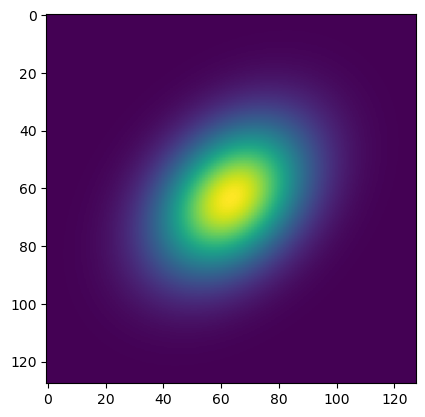

In [156]:
plt.imshow(f_fixed.reshape(n_pix, n_pix, n_pix).sum(2))

In [125]:
def loss(rotation):
    # Apply the rotation R to the coordinates
    rotated_xyz = xyz @ rotation.T
    # Compute the L2 loss between the two functions
    return torch.sum((f1(rotated_xyz, mu, inv_sigma) - f_fixed) ** 2)


angles = torch.linspace(44, 45, 100)
res = [
    loss(
        torch.from_numpy(R.from_euler("ZXZ", [x, 0, 0], degrees=True).as_matrix())
    ).item()
    for x in angles
]

<Axes: >

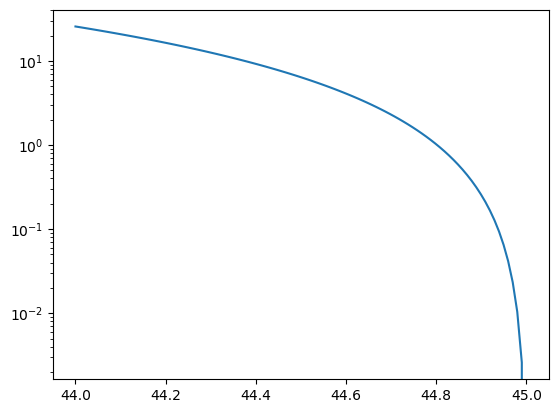

In [127]:
import pandas as pd

sr = pd.Series(res)
sr.index = angles.numpy()
sr.plot(logy=True)

# align voxelalized array
- do linear interpolation with torch.

In [ ]:
torch.nn.functional.grid_sample(..., mode="bilinear", padding_mode="zeros")

In [32]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Example 3D array (volume)
n_pix = 128
inv_sigma = (torch.diag(torch.tensor([1, 2, 10])) / 0.1).to(dtype)

volume = f_fixed = f1(xyz, mu, inv_sigma).reshape(1, 1, n_pix, n_pix, n_pix)

# Generate grid points
x = y = z = torch.linspace(-1, 1, n_pix).to(dtype)
xx, yy, zz = torch.meshgrid(x, y, z)
grid = torch.stack([xx, yy, zz], dim=-1)  # Shape: (D, H, W, 3)
# Reshape grid to match the expected input shape for grid_sample
grid = grid.unsqueeze(0)  # Add batch dimension, shape: (1, D, H, W, 3)


def voxelized_f1(volume, rotaiton, grid):
    grid = grid @ rotaiton.T
    # Interpolate the 3D array at the grid points
    interpolated_volume = F.grid_sample(
        volume,
        grid[..., [2, 1, 0]],
        mode="bilinear",
        padding_mode="zeros",
        align_corners=True,
    ).reshape(n_pix, n_pix, n_pix)
    return interpolated_volume


interpolated_volume = voxelized_f1(volume, fixed_rotation, grid)

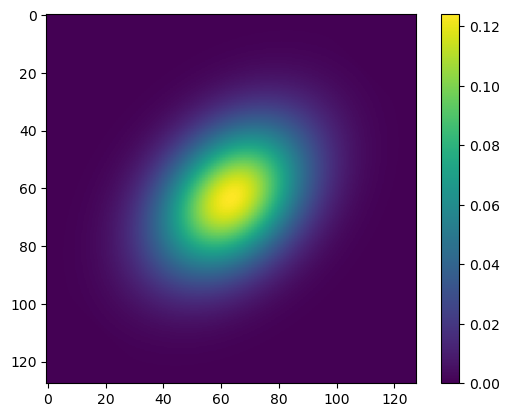

In [33]:
# Visualize a slice of the interpolated volume
slice_index = n_pix // 2
plt.imshow(interpolated_volume.mean(-1).detach().numpy())
plt.colorbar()
plt.show()

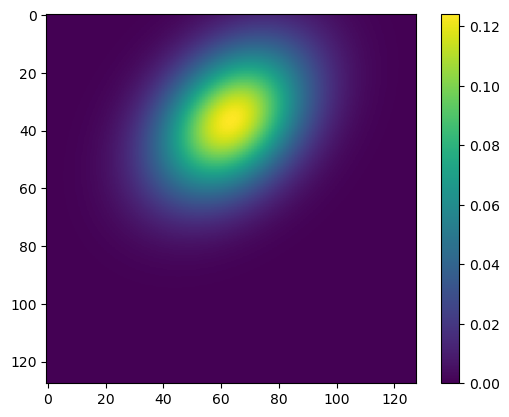

In [70]:
fixed_rotation = torch.from_numpy(
    R.from_euler("ZXZ", [45, 0, 0], degrees=True).as_matrix()
)
f_fixed = f1(xyz @ fixed_rotation.T + 0.3, mu, inv_sigma).reshape(n_pix, n_pix, n_pix)

plt.imshow(f_fixed.reshape(n_pix, n_pix, n_pix).mean(-1))
plt.colorbar()
plt.show()

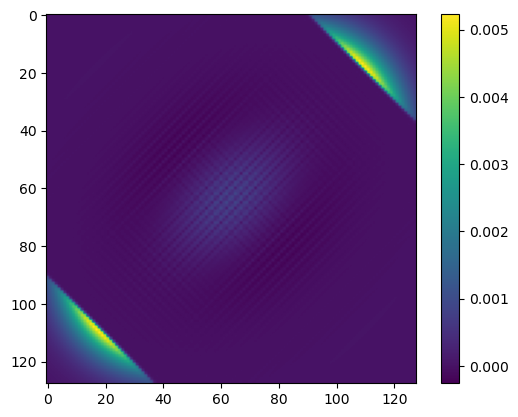

In [35]:
plt.imshow(
    f_fixed.reshape(n_pix, n_pix, n_pix)[:, :, n_pix // 2]
    - interpolated_volume.reshape(n_pix, n_pix, n_pix)[:, :, slice_index]
    .detach()
    .numpy()
)
plt.colorbar()
plt.show()

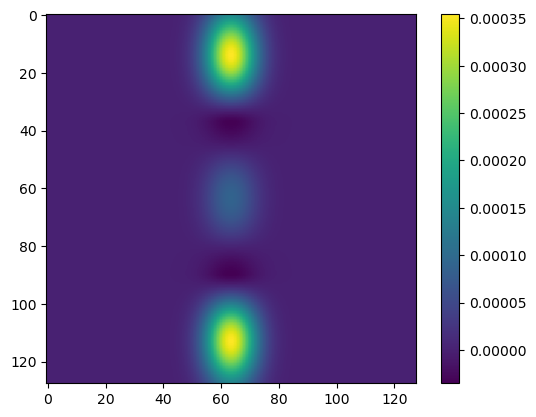

In [36]:
plt.imshow(
    f_fixed.reshape(n_pix, n_pix, n_pix).mean(-3)
    - interpolated_volume.mean(-3).detach().numpy()
)
plt.colorbar()
plt.show()

## optimize

In [17]:
import torch
import matplotlib.pyplot as plt
from pymanopt import Problem
from pymanopt.manifolds import SpecialOrthogonalGroup, Euclidean, Product
import pymanopt
from cryo_challenge._preprocessing.fourier_utils import downsample_volume
from scipy.spatial.transform import Rotation as R
import numpy as np

# # Define the Gaussian parameters
# mu = torch.tensor([0.5, 0.5, 0.5], requires_grad=False).to(dtype)
# inv_sigma = (torch.diag(torch.tensor([1.0, 2.0, 3.0], requires_grad=False)) / 0.1**2).to(dtype)

# Define the Gaussian parameters
dtype = torch.float64
mu = torch.tensor([0, 0, 0]).to(dtype)
inv_sigma = (torch.diag(torch.tensor([1.0, 2.0, 3.0])) / 0.1).to(dtype)


def prepare_grid(n_pix):
    x = y = z = torch.linspace(-1, 1, n_pix).to(dtype)
    xx, yy, zz = torch.meshgrid(x, y, z)
    xyz = torch.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

    grid = torch.stack([xx, yy, zz], dim=-1)  # Shape: (D, H, W, 3)
    # Reshape grid to match the expected input shape for grid_sample
    grid = grid.unsqueeze(0)  # Add batch dimension, shape: (1, D, H, W, 3)
    return xyz, grid


# Define the Gaussian function with a 3x3 covariance matrix
def f1(xyz, mu, inv_sigma):
    """
    Gaussian function centered at mu with covariance matrix sigma.
    """
    diff = xyz - mu
    exponent = -0.5 * torch.sum(diff @ inv_sigma * diff, axis=1)
    return torch.exp(exponent)


def voxelized_f1_rototranslation(volume, rotation, translation, grid):
    n_pix3 = grid.numel() / 3
    n_pix = round(n_pix3 ** (1 / 3))
    grid = grid @ rotation.T + translation
    # Interpolate the 3D array at the grid points
    interpolated_volume = F.grid_sample(
        volume,
        grid[..., [2, 1, 0]],
        mode="bilinear",
        padding_mode="zeros",
        align_corners=True,
    ).reshape(n_pix, n_pix, n_pix)
    return interpolated_volume


SO3 = SpecialOrthogonalGroup(n=3)  # Rotation group SO(3)
R3 = Euclidean(3)  # Euclidean space R^3
SE3 = Product([SO3, R3])  # SE(3) = SO(3) x R^3

fixed_rotation = torch.from_numpy(
    R.from_euler("ZXZ", [45, 0, 0], degrees=True).as_matrix()
)

n_pix = 128
xyz, _ = prepare_grid(n_pix)
dev = "cpu"
f_fixed = (
    f1(xyz @ fixed_rotation.T + 0.1, mu, inv_sigma).reshape(n_pix, n_pix, n_pix).to(dev)
)
volume = f1(xyz, mu, inv_sigma).reshape(n_pix, n_pix, n_pix).to(dev)

box_size_ds = n_pix // 4
f_fixed = downsample_volume(f_fixed, box_size_ds)
volume = downsample_volume(volume, box_size_ds).reshape(
    1, 1, box_size_ds, box_size_ds, box_size_ds
)

_, grid = prepare_grid(box_size_ds)
grid = grid.to(dev)

rotation = torch.eye(3).to(dev).to(dtype)
translation = torch.zeros(3).to(dev).to(dtype)

print(voxelized_f1_rototranslation(volume, rotation, translation, grid).device)


# Define the loss function (L2 loss)
@pymanopt.function.pytorch(SE3)
def loss(rotation, translation):
    # Apply the rotation R to the volume
    interpolated_volume = voxelized_f1_rototranslation(
        volume, rotation, translation, grid
    )
    # Compute the L2 loss between the two functions
    return torch.sum((interpolated_volume - f_fixed) ** 2)


# Generate a grid of 3D coordinates using meshgrid
# n_pix = 128
# dtype = torch.float64
# x = y = z = torch.linspace(0, 1, n_pix).to(dtype)
# xx, yy, zz = torch.meshgrid(x, y, z)
# xyz = torch.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T


# Define the manifold
# manifold = SpecialOrthogonalGroup(3)

# Define the problem
problem = Problem(manifold=SE3, cost=loss)

# Solve the problem with the custom solver
optimizer = TrustRegions(
    max_iterations=100,
)

initial_translation = np.zeros(3)
initial_rotation = R.from_euler("ZXZ", [44, 0, 0], degrees=True).as_matrix()
# initial_translation = torch.from_numpy(initial_translation).to(dev).to(dtype)
# initial_rotation = torch.from_numpy(initial_rotation).to(dev).to(dtype)
initial_point = (initial_rotation, initial_translation)

result = optimizer.run(problem, initial_point=initial_point)

print("Optimal rotation matrix (R):")
print(result)

# Visualize the result
f = f1(xyz, mu, inv_sigma).detach().numpy()
plt.imshow(f.reshape(n_pix, n_pix, n_pix).sum(2))
plt.show()

cpu
Optimizing...
                                            f: +8.129187e+01   |grad|: 8.775696e+02


RuntimeError: derivative for aten::grid_sampler_3d_backward is not implemented

In [18]:
input = torch.tensor(
    [[[[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]]]], dtype=torch.float64, requires_grad=True
)

# 2x3x2
grid = torch.tensor(
    [
        [  # x,y
            [
                [1.0, 1.0],  # 1
                [-1.0, -1.0],  # 6
                [0.0, 1.0],
            ],  # 5
            [
                [0.0, 0.0],  # between 2 and 5   == (2 + 5) / 2 == 3.5
                [0.0, 0.5],  # between 3.5 and 5 == (3.5 + 5) / 2 == 4.25
                [-1.0, -1.0],
            ],
        ]
    ],  # etc
    dtype=torch.float64,
    requires_grad=True,
)

interpolation_mode = "bilinear"
padding_mode = "zeros"
align_corners = True

res = torch.nn.functional.grid_sample(
    input, grid, interpolation_mode, padding_mode, align_corners
)
res.mean().backward()
print(input.grad)

tensor([[[[0.3333, 0.1250, 0.0000],
          [0.0000, 0.3750, 0.1667]]]], dtype=torch.float64)


In [38]:
res.mean()

tensor(3.4583, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [39]:
n_pix = 16
_, grid = prepare_grid(n_pix)
volume = torch.randn(1, 1, n_pix, n_pix, n_pix, requires_grad=True).to(dev).to(dtype)
rotation = torch.eye(3).to(dev).to(dtype)
translation = 0.1 * torch.ones(3).to(dev).to(dtype)
interpolated_volume = voxelized_f1_rototranslation(volume, rotation, translation, grid)
mse = torch.linalg.norm(volume - interpolated_volume).reshape(1)
mse.backward()

 ### SE(3)

In [49]:
import numpy as np
import pymanopt
from pymanopt.manifolds import SpecialOrthogonalGroup, Euclidean, Product

# Define the SE(3) manifold as a product of SO(3) and R^3
SO3 = SpecialOrthogonalGroup(n=3)  # Rotation group SO(3)
R3 = Euclidean(3)  # Euclidean space R^3
SE3 = Product([SO3, R3])  # SE(3) = SO(3) x R^3


# Cost function: Example of a simple objective function
@pymanopt.function.pytorch(SE3)
def cost(R, t):
    # R, t = R_t  # Unpack rotation and translation
    # Example: Encourage rotation towards identity and translation towards (1,1,1)
    return (
        torch.linalg.norm(R - torch.eye(3), "fro") ** 2
        + torch.linalg.norm(t - torch.tensor([1, 1, 1])) ** 2
    )


# Create a PyManopt problem
problem = pymanopt.Problem(manifold=SE3, cost=cost)

# Solve using steepest descent
optimizer = SteepestDescent()
result = optimizer.run(problem)

# Print results
R_opt, t_opt = result.point
print("Optimized Rotation Matrix:\n", R_opt)
print("Optimized Translation Vector:\n", t_opt)

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +8.9181457021998938e+00    1.98166095e+00    
   2         +7.8727862490156468e+00    7.08098777e-01    
   3         +3.9445451848365236e+00    2.84203409e+00    
   4         +3.2298062102698766e-01    1.13127294e+00    
   5         +4.7943207251817097e-02    4.37708909e-01    
   6         +9.1710798524183464e-03    1.91513520e-01    
   7         +2.8980459440325293e-05    1.07666975e-02    
   8         +1.5647221139102670e-06    2.50177702e-03    
   9         +1.4137210697903066e-08    2.37800006e-04    
  10         +7.2024887120668901e-09    1.69734955e-04    
  11         +6.1711856509558534e-09    1.57113789e-04    
  12         +2.7353608930097905e-09    1.04601355e-04    
  13         +1.7937442351506737e-10    2.67861474e-05    
  14         +1.0946195520463226e-10    2.09248135e-05    
  15         +8.4222151037693660e-12    5.

# inspect

In [ ]:
# id_dict = {}
# for fname in glob('/mnt/home/smbp/ceph/smbpchallenge/round1/set2/processed_submissions/submission_*.pt'):
#     num = int(fname.split('/')[-1].split('.')[0].split('_')[-1])

#     if os.path.isfile(fname) and num not in d:
#         data = torch.load(fname)
#         id_dict[num] = data['id']

In [35]:
id_dict = {
    12: "Neapolitan 2",
    21: "Salted Caramel 2",
    20: "Rocky Road 2",
    23: "Mint Chocolate Chip 1",
    16: "Vanilla 2",
    15: "Cherry 2",
    26: "Salted Caramel 5",
    24: "Bubble Gum 1",
    25: "Salted Caramel 4",
    19: "Rocky Road 3",
    14: "Pina Colada 1",
    22: "Salted Caramel 3",
    18: "Peanut Butter 2",
    13: "Chocolate 2",
    29: "test_mango_identical",
    17: "Cookie Dough 2",
    99: "Noise",
    4: "Neapolitan",
    6: "Rocky Road",
    7: "Peanut Butter",
    2: "Black Raspberry",
    10: "Mango",
    9: "Vanilla",
    8: "Chocolate Chip",
    5: "Cookie Dough",
    1: "Salted Caramel",
    3: "Chocolate",
    11: "Cherry",
    0: "Coffee",
}

In [15]:
ds = 32
fname = f"/mnt/home/gwoollard/ceph/repos/Cryo-EM-Heterogeneity-Challenge-1/src/cryo_challenge/_map_to_map/alignment/alignments_se3_ni80_nj80_ds{ds}_ConjugateGradient_submission_13-vs-submission_23.pt"
results = torch.load(fname)

/tmp/ipykernel_2827320/357717264.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load(fname)


In [ ]:
def compute_geodesic_angle(rotations):
    assert rotations.shape[2:] == (3, 3)
    trace = torch.einsum("...ii", rotations.reshape(-1, 3, 3))
    geodesic_angle = torch.arccos((trace - 1) / 2)
    geodesic_angle_deg = torch.rad2deg(geodesic_angle)
    geodesic_angle_deg = geodesic_angle_deg.reshape(rotations.shape[:2])
    return geodesic_angle_deg

'20'

/tmp/ipykernel_2827320/1271361940.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load(fname)


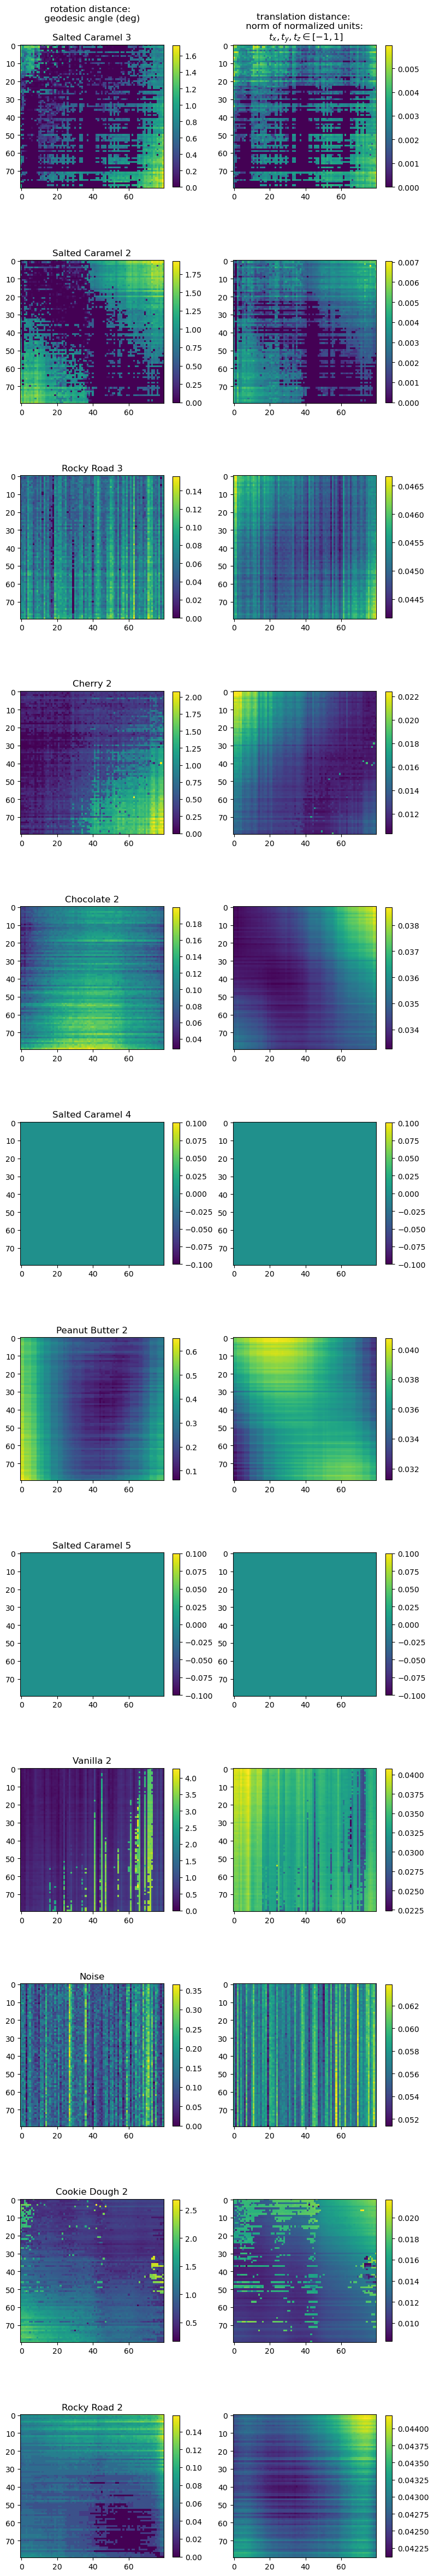

In [77]:
ds = 32
fnames = glob(
    f"/mnt/home/gwoollard/ceph/repos/Cryo-EM-Heterogeneity-Challenge-1/src/cryo_challenge/_map_to_map/alignment/alignments_se3_ni80_nj80_ds{ds}_ConjugateGradient_submission_*-vs-submission_23.pt"
)
cb_shrink = 0.7
base = 4
fig, axes = plt.subplots(
    nrows=len(fnames), ncols=2, figsize=(2 * base, base * len(fnames))
)
for idx, fname in enumerate(fnames):
    num = int(fname.split("/")[-1].split(".")[0].split("submission")[-2][1:3])
    identity = id_dict[num]

    results = torch.load(fname)
    key = "alignments" if "alignments" in results else "rotations"
    rotations = results[key]
    geodesic_angle_deg = compute_geodesic_angle(rotations)
    # Plot geodesic angle
    im1 = axes[idx, 0].imshow(geodesic_angle_deg.T)
    pre = ""
    if idx == 0:
        pre = "rotation distance: \n geodesic angle (deg) \n\n"

    axes[idx, 0].set_title(pre + identity)
    fig.colorbar(im1, ax=axes[idx, 0], shrink=cb_shrink)

    # Plot translation distance
    im2 = axes[idx, 1].imshow(results["translations"].norm(dim=-1).T)
    if idx == 0:
        pre = (
            "translation distance: \n norm of normalized units: \n "
            + r"$ t_x,t_y,t_z \in [-1,1]$"
        )
    axes[idx, 1].set_title(pre)
    fig.colorbar(im2, ax=axes[idx, 1], shrink=cb_shrink)

plt.tight_layout()

In [ ]:
import pandas as pd

pd.Series(results["loss_final"].numpy().flatten()).plot.hist(
    bins=45, alpha=0.5, label="final loss (after updating pose)", legend=True
)
pd.Series(results["loss_initial"].numpy().flatten()).plot.hist(
    bins=45, alpha=0.5, label="initial loss", legend=True
)
plt.title(f"Histogram of L2 loss values | ds={ds}")

In [ ]:
plt.imshow(results["loss_final"].numpy())
plt.colorbar()
plt.title(f"final L2 loss | downsample={ds}")
plt.show()

plt.imshow(results["loss_initial"].numpy())
plt.title(f"initial L2 loss | downsample={ds}")
plt.colorbar()
plt.show()

# residual
plt.imshow(results["loss_initial"].numpy() - results["loss_final"].numpy())
plt.title(f"residual L2 loss: initial - final | downsample={ds}")
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'rotation distance: geodesic angle (deg) | downsample=32')

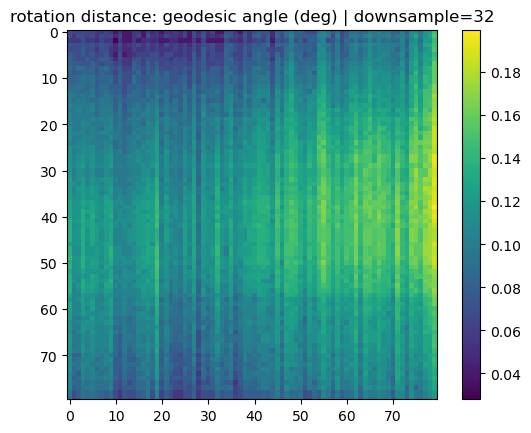

In [17]:
plt.imshow(geodesic_angle_deg)
plt.colorbar()
plt.title(f"rotation distance: geodesic angle (deg) | downsample={ds}")

Text(0.5, 1.0, 'translation distance: norm of normalized units: $ t_x,t_y,t_z \\in [-1,1]$ | downsample=32')

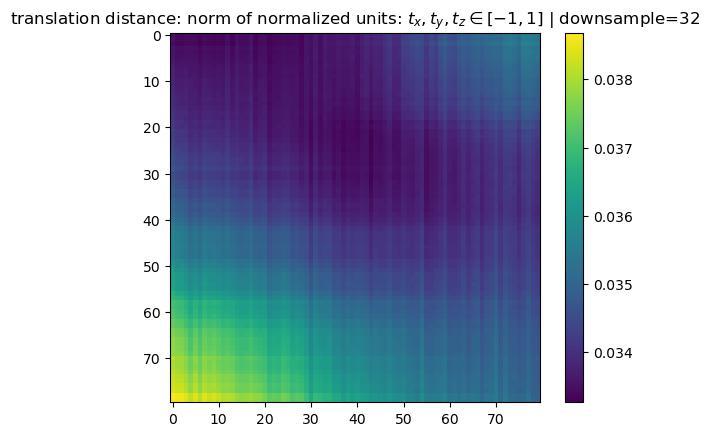

In [18]:
plt.imshow(results["translations"].norm(dim=-1))
plt.colorbar()
plt.title(
    rf"translation distance: norm of normalized units: $ t_x,t_y,t_z \in [-1,1]$ | downsample={ds}"
)

In [8]:
fname = "/mnt/home/smbp/ceph/smbpchallenge/round2/set2/processed_submissions/submission_23.pt"
submission = torch.load(fname, weights_only=False)

torch_dtype = torch.float32
volumes = submission["volumes"].to(torch_dtype)

KeyError: 'interpolated_volumes_i_to_j'

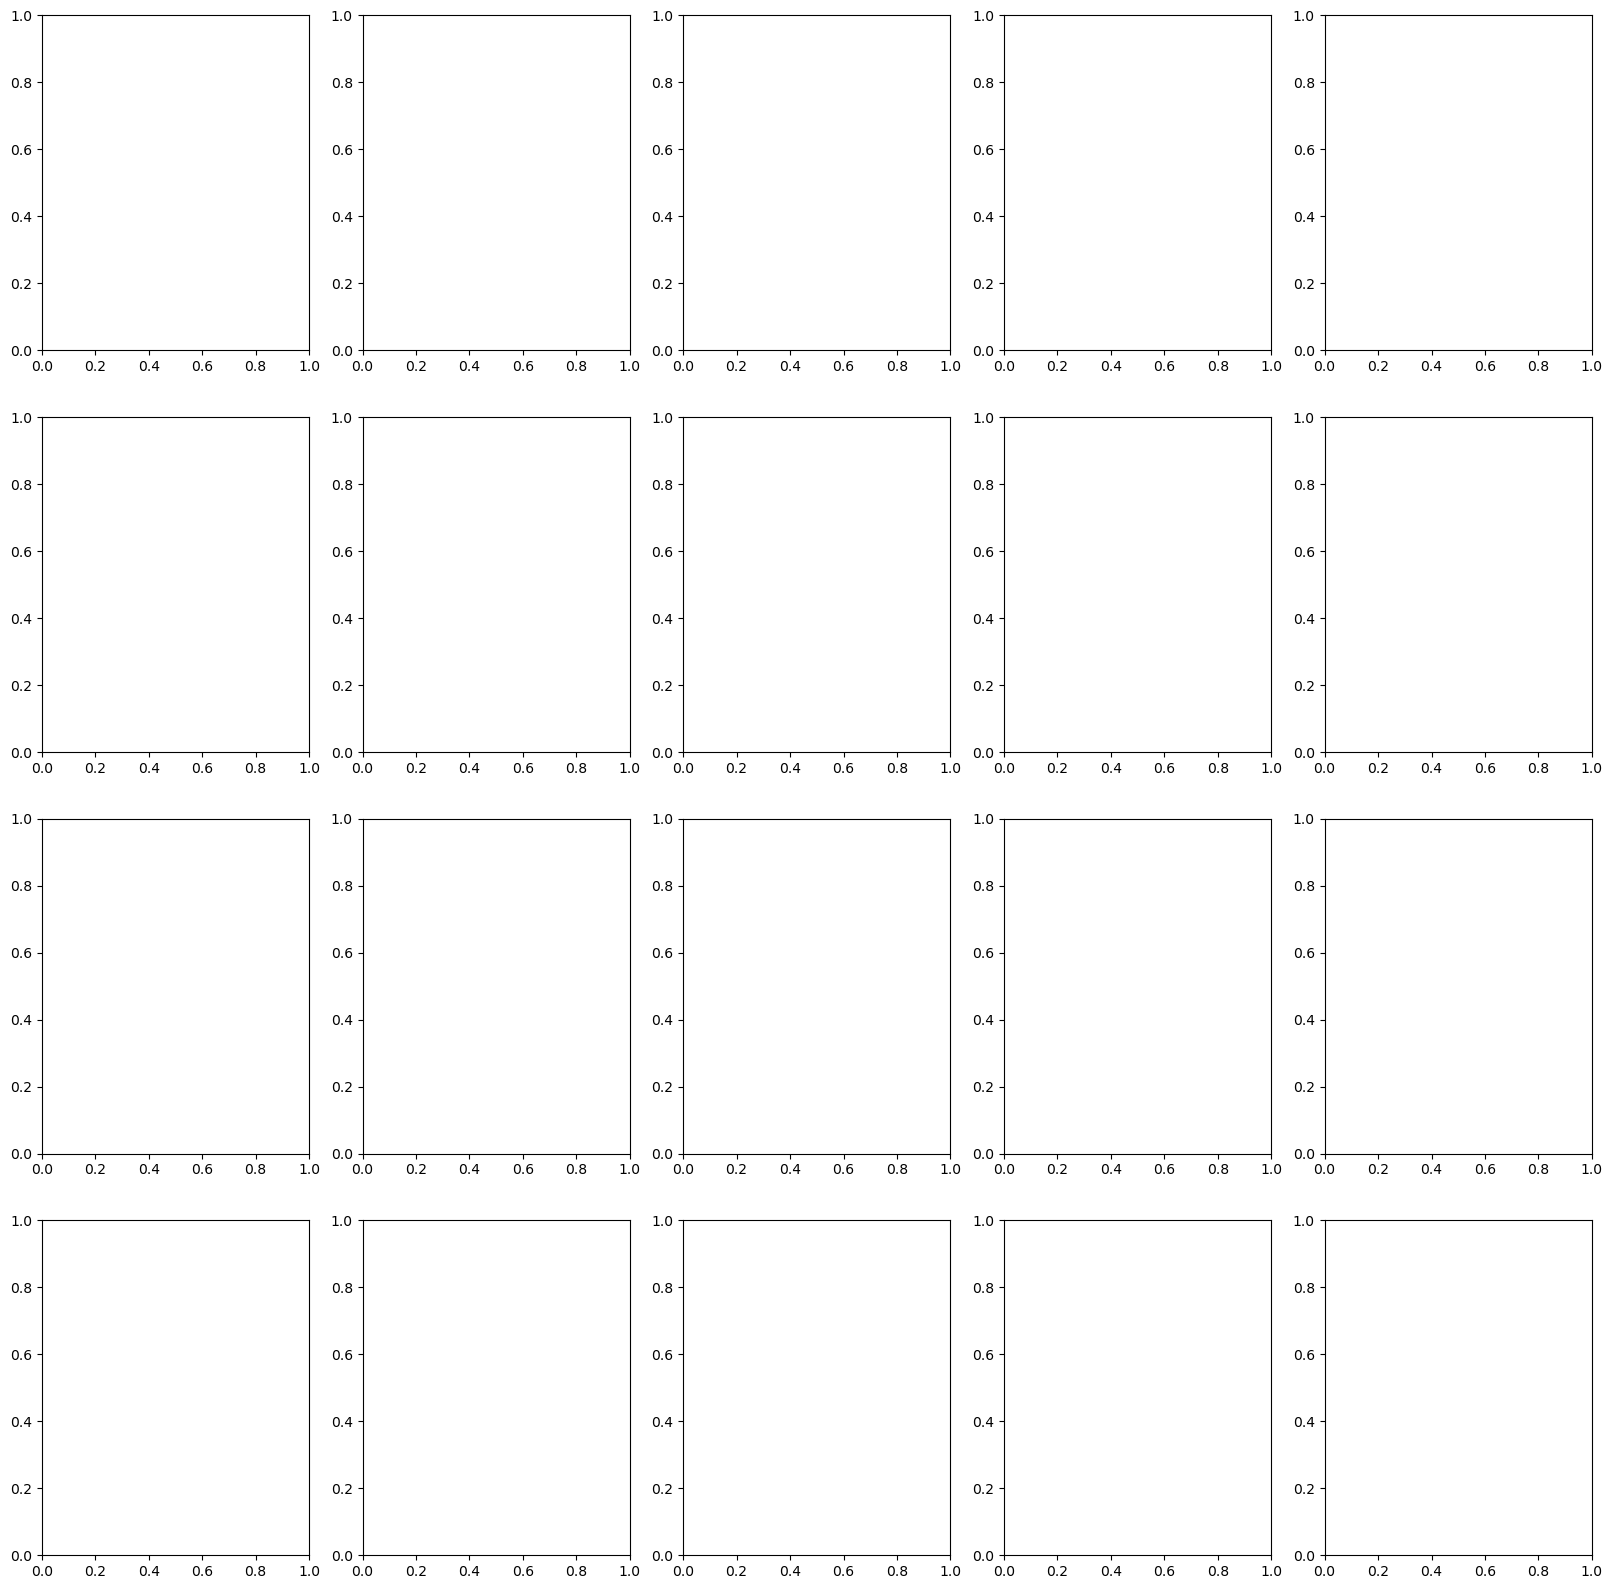

In [ ]:
_I, J = 4, 4
dim = -3

fig, axes = plt.subplots(_I, J + 1, figsize=(20, 20))
proj = results["interpolated_volumes_i_to_j"].mean(dim)

for i, j in [(i, j) for i in range(_I) for j in range(J)]:
    axes[i, j + 1].imshow(proj[i, j])
    axes[i, j + 1].set_title(f"i={i}, j={j}")
    # # colorbars
    # if j == J-1:
    #     plt.colorbar(axes[i,j+1].imshow(proj[i,j]), ax=axes[i,j+1])

for i in range(_I):
    axes[i, 0].imshow(volumes[i].mean(dim).numpy())
    # colorbar
    plt.colorbar(axes[i, 0].imshow(volumes[i].mean(dim)), ax=axes[i, 0])

# multiprocessing

In [29]:
from cryo_challenge._map_to_map.alignment.map_alignment import align, prepare_grid
from cryo_challenge._preprocessing.fourier_utils import downsample_volume

In [ ]:
import torch
import numpy as np
import multiprocessing as mp
import logging
from functools import partial

# Configure logging
logging.basicConfig(
    filename="alignment.log",  # Log file
    level=logging.INFO,  # Log level: INFO, DEBUG, WARNING, ERROR
    format="%(asctime)s - %(levelname)s - %(message)s",
)

semaphore = mp.Semaphore(4)
mp.set_start_method("spawn", force=True)


def minimal_process_pair(idx_i, idx_j, volume_i, volume_j, box_size_ds, grid):
    """Aligns a pair of volumes and logs progress."""
    with semaphore:
        try:
            volume_i = volume_i.clone()
            volume_j = volume_j.clone()
            logging.info(f"Starting alignment for pair ({idx_i}, {idx_j})")
            logging.info(f"({idx_i}, {idx_j}) is shared memory? {volume_i.is_shared()}")

            # volume_i_ds = downsample_volume(volume_i, box_size_ds)
            _ = align(volume_i, volume_j)

            # volume_j_ds = downsample_volume(volume_j, box_size_ds)

            # result = align(volume_i_ds, volume_j_ds)
            # rotation, translation = result.point

            # volume_i_aligned_to_j = interpolate_volume(
            #     volume_i, rotation, translation, grid
            # ).reshape(len(volume_i), len(volume_i), len(volume_i))

            # loss_initial = loss_l2(volume_i, volume_j)
            # loss_final = loss_l2(volume_i_aligned_to_j, volume_j)
            rotation = np.eye(3)
            translation = np.zeros(3)
            loss_initial = 0
            loss_final = torch.tensor(0.0)

            logging.info(
                f"Finished alignment for pair ({idx_i}, {idx_j}) - Loss: {loss_final.item():.4f}"
            )

            return idx_i, idx_j, rotation, translation, loss_initial, loss_final

        except Exception as e:
            logging.error(f"Error in alignment for pair ({idx_i}, {idx_j}): {e}")
            return idx_i, idx_j, None, None, None, None  # Handle errors gracefully


def main(args):
    fname = "/mnt/home/smbp/ceph/smbpchallenge/round2/set2/processed_submissions/submission_23.pt"
    logging.info(f"Loading submission file: {fname}")

    submission = torch.load(fname, weights_only=False)

    torch_dtype = torch.float64
    volumes = submission["volumes"].to(torch_dtype).cpu().contiguous()
    _volumes_i = volumes[: args.n_i]
    _volumes_j = volumes[: args.n_j]
    box_size_ds = args.downsample_box_size_ds

    volumes_i = torch.empty(
        (args.n_i, box_size_ds, box_size_ds, box_size_ds), dtype=torch_dtype
    )
    volumes_j = torch.empty(
        (args.n_j, box_size_ds, box_size_ds, box_size_ds), dtype=torch_dtype
    )
    for i, v in enumerate(_volumes_i):
        volumes_i[i] = downsample_volume(v, box_size_ds)
    for j, v in enumerate(_volumes_j):
        volumes_j[j] = downsample_volume(v, box_size_ds)

    # Prepare grid (shared for all processes)
    n_pix = len(volumes_i[0])
    grid = prepare_grid(n_pix, torch_dtype)

    logging.info(f"Starting multiprocessing with {args.n_i * args.n_j} jobs")

    num_workers = min(mp.cpu_count() // 2, args.n_i * args.n_j)
    pool = mp.Pool(num_workers)

    process_func = partial(minimal_process_pair, box_size_ds=box_size_ds, grid=grid)
    n_pix_mp = 100
    jobs = [
        (
            idx_i,
            idx_j,
            volumes_i[idx_i, :n_pix_mp, :n_pix_mp, :n_pix_mp],
            volumes_j[idx_j],
        )
        for idx_i in range(args.n_i)
        for idx_j in range(args.n_j)
    ]

    results = pool.starmap(process_func, jobs)

    pool.close()
    pool.join()

    logging.info("Multiprocessing finished. Collecting results...")

    size_of_rotation_matrix = (3, 3)
    size_of_translation_vector = (3,)

    rotations = torch.empty((args.n_i, args.n_j) + size_of_rotation_matrix)
    translations = torch.empty((args.n_i, args.n_j) + size_of_translation_vector)
    loss_initial = torch.empty(args.n_i, args.n_j, 1)
    loss_final = torch.empty(args.n_i, args.n_j, 1)

    for idx_i, idx_j, rotation, translation, li, lf in results:
        if rotation is not None:
            rotations[idx_i, idx_j] = torch.from_numpy(rotation)
            translations[idx_i, idx_j] = torch.from_numpy(translation)
            loss_initial[idx_i, idx_j] = li
            loss_final[idx_i, idx_j] = lf
        else:
            logging.warning(f"Skipping ({idx_i}, {idx_j}) due to errors.")

    logging.info("Processing complete.")

    return {
        "rotation": rotations,
        "translation": translations,
        "loss_initial": loss_initial,
        "loss_final": loss_final,
    }


class Args:
    n_i = 1
    n_j = 1
    downsample_box_size_ds = 8


args = Args()
results = main(args)

2025-02-20 18:45:44,643 INFO [root] Loading submission file: /mnt/home/smbp/ceph/smbpchallenge/round2/set2/processed_submissions/submission_23.pt
2025-02-20 18:45:47,375 INFO [root] Starting multiprocessing with 1 jobs


Process SpawnPoolWorker-9:
Traceback (most recent call last):
  File "/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'process_pair' on <module '__main__' (built-in)>
Process SpawnPoolWorker-10:
Traceback (most recent call last):
  File "/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/multiprocessin

KeyboardInterrupt: 

In [ ]:
import torch
import multiprocessing as mp
import logging

# Enable logging to debug errors
logging.basicConfig(level=logging.ERROR)

# Ensure the multiprocessing context uses 'spawn'
mp.set_start_method("spawn", force=True)


def process_pair(idx_i, idx_j, volume_i, volume_j, box_size_ds):
    """Aligns two volumes and returns the results."""
    try:
        # volume_i_ds = downsample_volume(volume_i, box_size_ds)
        # volume_j_ds = downsample_volume(volume_j, box_size_ds)
        volume_i = volume_i.clone()
        volume_j = volume_j.clone()
        logging.info(f"Starting alignment for pair ({idx_i}, {idx_j})")
        logging.info(f"({idx_i}, {idx_j}) is shared memory? {volume_i.is_shared()}")
        result = align(volume_i, volume_j)
        return result
        # rotation, translation = result.point

        # loss_init = loss_l2(volume_i, volume_j)
        # volume_i_aligned_to_j = interpolate_volume(volume_i, rotation, translation).reshape(*volume_i.shape)
        # loss_final = loss_l2(volume_i_aligned_to_j, volume_j)

        # return idx_i, idx_j, rotation, translation, loss_init, loss_final

    except Exception as e:
        logging.error(f"Error in alignment for pair ({idx_i}, {idx_j}): {e}")
        return idx_i, idx_j, None, None, None, None


def main(args):
    fname = "/mnt/home/smbp/ceph/smbpchallenge/round2/set2/processed_submissions/submission_23.pt"
    submission = torch.load(fname, weights_only=False)

    torch_dtype = torch.float32  # Use float32 to reduce memory usage
    volumes = submission["volumes"].to(torch_dtype)

    _volumes_i = volumes[: args.n_i]
    _volumes_j = volumes[: args.n_j]
    box_size_ds = args.downsample_box_size_ds

    volumes_i = torch.empty(
        (args.n_i, box_size_ds, box_size_ds, box_size_ds), dtype=torch_dtype
    )
    volumes_j = torch.empty(
        (args.n_j, box_size_ds, box_size_ds, box_size_ds), dtype=torch_dtype
    )
    for i, v in enumerate(_volumes_i):
        volumes_i[i] = downsample_volume(v, box_size_ds)
    for j, v in enumerate(_volumes_j):
        volumes_j[j] = downsample_volume(v, box_size_ds)
    box_size_ds = args.downsample_box_size_ds

    rotations = torch.empty((args.n_i, args.n_j, 3, 3))
    translations = torch.empty((args.n_i, args.n_j, 3))
    loss_initial = torch.empty((args.n_i, args.n_j, 1))
    loss_final = torch.empty((args.n_i, args.n_j, 1))

    # Prepare arguments for starmap
    tasks = []
    for idx_i, volume_i in enumerate(volumes_i):
        for idx_j, volume_j in enumerate(volumes_j):
            tasks.append(
                (idx_i, idx_j, volume_i.clone(), volume_j.clone(), box_size_ds)
            )

    # Use multiprocessing with starmap
    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.starmap(process_pair, tasks)

    # Store results
    for idx_i, idx_j, rotation, translation, loss_init, loss_fin in results:
        if rotation is not None:
            rotations[idx_i, idx_j] = torch.from_numpy(rotation)
            translations[idx_i, idx_j] = torch.from_numpy(translation)
            loss_initial[idx_i, idx_j] = loss_init
            loss_final[idx_i, idx_j] = loss_fin

    return {
        "rotation": rotations,
        "translation": translations,
        "loss_initial": loss_initial,
        "loss_final": loss_final,
    }


class Args:
    n_i = 1
    n_j = 1
    downsample_box_size_ds = 8


args = Args()
results = main(args)

Process SpawnPoolWorker-78:
Traceback (most recent call last):
  File "/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'process_pair' on <module '__main__' (built-in)>
Process SpawnPoolWorker-138:
Process SpawnPoolWorker-140:
Process SpawnPoolWorker-135:
Process SpawnPoolWorker-134:
Process SpawnPoolWorker-141:
Process SpawnP

# 